In [1]:
%matplotlib widget

In [2]:
import argparse
import os
import pickle
import pandas as pd
import numpy as np
import torch

import pyro
import pyro.infer
import pyro.infer.mcmc
import pyro.distributions as dist

import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Let's generate data for 18 models, 1000 examples, with a, b, theta, gamma, parameters.
a, b, theta are multiple dimensions.

## Lets define prior distribution

In [3]:
def set_seeds(seed):
    np.random.seed(seed)
    pyro.set_rng_seed(seed)
    torch.manual_seed(seed)

def sigmoid(x):
    return 1.0 / (1.0 + torch.exp(-x))

In [4]:
seed=42
diff="normal"
discr="lognormal"
guess="normal"
ability="normal"

diff_transform="identity"
discr_transform="identity"
guess_transform="identity"
ability_transform="identity"

alpha_std=1
item_param_std=1
dimension=3


dist_type="multivariate"

In [5]:
set_seeds(seed)

# defining dataset sizes
n_models, n_items = 18, 3000
dimension=3

# Fix params for alpha and gamma

Let's fix alpha and gamma to be easier.

In [6]:
gamma = torch.ones(n_items) * 0.5
alphas = torch.ones(n_items, dimension)

In [7]:
dist_parms_0 = {"mu": 10, "std": 1}
dist_parms_1 = {"mu": -5, "std": 2}
dist_parms_2 = {"mu": -2, "std": 1}

pos_dist = dist.Normal(dist_parms_0['mu'] * torch.ones(n_items//dimension, 1), dist_parms_0['std'])
neg_dist_1 = dist.Normal(dist_parms_1['mu'] * torch.ones(n_items//dimension, 1), dist_parms_1['std'])
neg_dist_2 = dist.Normal(dist_parms_2['mu'] * torch.ones(n_items//dimension, 1), dist_parms_2['std'])

In [8]:
# pos, neg1, neg2
beta_dim_0 = pos_dist.sample()
beta_dim_1 = neg_dist_1.sample()
beta_dim_2 = neg_dist_2.sample()
beta_0 = torch.cat((beta_dim_0, beta_dim_1, beta_dim_2),1)

#neg2, pos, neg1
beta1_dim_0 = neg_dist_2.sample()
beta1_dim_1 = pos_dist.sample()
beta1_dim_2 = neg_dist_1.sample()
beta_1 = torch.cat((beta1_dim_0, beta1_dim_1, beta1_dim_2),1)

#neg1, neg2, pos
beta2_dim_0 = neg_dist_1.sample()
beta2_dim_1 = neg_dist_2.sample()
beta2_dim_2 = pos_dist.sample()
beta_2 = torch.cat((beta2_dim_0, beta2_dim_1, beta2_dim_2),1)



In [9]:
betas = torch.vstack([beta_0, beta_1, beta_2])


In [32]:
dist_parms_0 = {"mu": 6, "std": 2}
dist_parms_1 = {"mu": -2, "std": 2}
dist_parms_2 = {"mu": -5, "std": 1}

n_models=15
# define thetas
pos_dist_t = dist.Normal(dist_parms_0['mu'] * torch.ones(n_models//(dimension), 1), dist_parms_0['std'])
neg_dist_1 = dist.Normal(dist_parms_1['mu'] * torch.ones(n_models//(dimension), 1), dist_parms_1['std'])
neg_dist_t2 = dist.Normal(dist_parms_2['mu'] * torch.ones(n_models//(dimension), 1), dist_parms_2['std'])

In [33]:

# pos, neg1, neg2
theta_dim_0 = pos_dist_t.sample()
theta_dim_1 = neg_dist_1.sample()
theta_dim_2 = neg_dist_t2.sample()
theta_0 = torch.cat((theta_dim_0, theta_dim_1, theta_dim_2),1)

#neg2, pos, neg1
theta1_dim_0 = neg_dist_t2.sample()
theta1_dim_1 = pos_dist_t.sample()
theta1_dim_2 = neg_dist_1.sample()
theta_1 = torch.cat((theta1_dim_0, theta1_dim_1, theta1_dim_2),1)

#neg1, neg2, pos
theta2_dim_0 = neg_dist_1.sample()
theta2_dim_1 = neg_dist_t2.sample()
theta2_dim_2 = pos_dist_t.sample()
theta_2 = torch.cat((theta2_dim_0, theta2_dim_1, theta2_dim_2),1)

# pos, neg2, pos
#theta3_dim_0 = pos_dist_t.sample()
#theta3_dim_1 = neg_dist_t2.sample()
#theta3_dim_2 = neg_dist_1.sample()
#theta_3 = torch.cat((theta3_dim_0, theta3_dim_1, -1* theta3_dim_2),1)

# neg, neg, neg
theta4_dim_0 = neg_dist_1.sample()
theta4_dim_1 = neg_dist_t2.sample()
theta4_dim_2 = pos_dist_t.sample()
theta_4 = torch.cat((theta4_dim_0, theta4_dim_1, -1 * theta4_dim_2),1)

# neg, pos, pos
#theta5_dim_0 = neg_dist_t2.sample()
#theta5_dim_1 = pos_dist_t.sample()
#theta5_dim_2 = pos_dist_t.sample()
#theta_5 = torch.cat((theta5_dim_0, -theta5_dim_1, theta5_dim_2),1)



In [39]:

thetas = torch.vstack([theta_0, theta_1, theta_2, theta_4]) #, theta_3, theta_4, theta_5])
thetas.size()

torch.Size([20, 3])

In [48]:

if dimension > 1:
    probs = gamma[None, :]  + (1.0 - gamma[None, :])   * sigmoid( 1./np.sqrt(dimension) * torch.sum(alphas[None, :, :] * (thetas[:, None] - betas[None, :]).squeeze(), dim=-1))
else:
    probs = gamma[None, :] + (1.0 - gamma[None, :]) * sigmoid(alphas[None, :] * (thetas[:, None] - betas[None, :]))
lik = dist.Bernoulli(probs).sample()

lik.size()


torch.Size([20, 3000])

In [49]:
n_models=lik.size(0)
lik = dist.Bernoulli(probs).sample()
(lik.sum(0)/n_models == 1).sum()

tensor(0)

In [50]:
import torch.nn.functional as F
F.mse_loss(0.5*torch.ones(20,3000), probs)

tensor(0.0351)

In [51]:
probs


tensor([[0.5498, 0.6327, 0.5687,  ..., 0.9030, 0.8848, 0.5708],
        [0.5042, 0.5136, 0.5061,  ..., 0.6216, 0.6026, 0.5063],
        [0.5685, 0.6706, 0.5929,  ..., 0.9282, 0.9137, 0.5956],
        ...,
        [0.5000, 0.5001, 0.5000,  ..., 0.5013, 0.5010, 0.5001],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5001, 0.5002, 0.5001,  ..., 0.5024, 0.5020, 0.5001]])

In [52]:

model_names = ["model_{}".format(i) for i in range(n_models)]
items_names = [f"data_fix-ac_d{dimension}_diffskills" for i in range(n_items)]

df = pd.DataFrame(data=lik.numpy().astype(int),
                  index=model_names,
                  columns=items_names)
df.index.names = ['userid']

param_dict = {
        "a": alphas.numpy(),
        "b": betas.numpy(),
        "g": gamma.numpy(),
        "t": thetas.numpy(),
        "probs": probs.numpy()
}


In [46]:
response_dir="/Users/phumon/Documents/Research/nlu-mirt/data_sync/diff_skills"

In [53]:
with open(os.path.join(response_dir, f'params_varied_sync_dim{dimension}_diffskills_irt_all_coded.p'), 'wb') as handle:
    pickle.dump(param_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

response_output=os.path.join(response_dir, f'sync_varied_dim{dimension}_diffskills_irt_all_coded.csv')
df.to_csv(response_output)
   

In [54]:
df

,data_fix-ac_d3_diffskills,data_fix-ac_d3_diffskills,data_fix-ac_d3_diffskills,data_fix-ac_d3_diffskills,data_fix-ac_d3_diffskills,data_fix-ac_d3_diffskills,data_fix-ac_d3_diffskills,data_fix-ac_d3_diffskills,data_fix-ac_d3_diffskills,data_fix-ac_d3_diffskills,...,data_fix-ac_d3_diffskills,data_fix-ac_d3_diffskills,data_fix-ac_d3_diffskills,data_fix-ac_d3_diffskills,data_fix-ac_d3_diffskills,data_fix-ac_d3_diffskills,data_fix-ac_d3_diffskills,data_fix-ac_d3_diffskills,data_fix-ac_d3_diffskills,data_fix-ac_d3_diffskills
userid,,,,,,,,,,,,,,,,,,,,,
model_0,1,1,1,1,1,1,0,1,1,1,...,0,1,0,1,1,1,1,1,1,0
model_1,1,0,0,0,1,0,0,1,1,1,...,0,1,1,0,0,1,0,1,0,1
model_2,1,1,1,1,1,0,1,0,1,1,...,1,1,0,1,1,0,1,1,1,1
model_3,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
model_4,1,0,1,0,0,1,0,0,0,0,...,1,0,0,1,0,1,0,1,0,0
model_5,1,1,0,1,1,0,0,1,1,1,...,0,0,1,1,1,0,1,1,1,1
model_6,1,1,1,1,0,1,1,1,0,1,...,1,0,1,1,1,0,1,1,1,1
model_7,1,1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,1,0,1
model_8,1,0,0,1,1,0,1,0,0,0,...,0,1,0,0,0,1,0,0,1,1


Populating the interactive namespace from numpy and matplotlib


/Users/phumon/opt/anaconda3/envs/latent_features/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['gamma', 'diff', 'seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
/Users/phumon/opt/anaconda3/envs/latent_features/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:189: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([xs, ys, zs, np.ones_like(xs)])


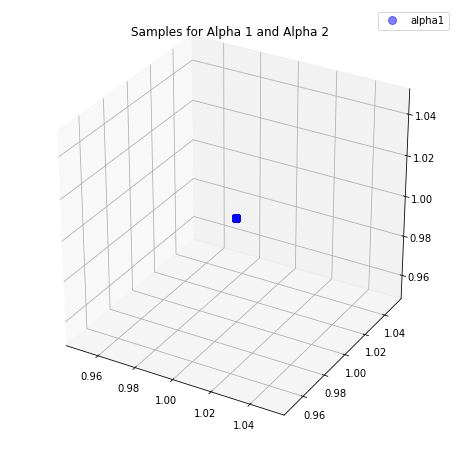

In [55]:
%pylab inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10   
ax.plot(alphas.T[0,:], alphas.T[1,:], alphas.T[2,:], 'o', markersize=8, color='blue', alpha=0.5, label='alpha1')
plt.title('Samples for Alpha 1 and Alpha 2')
ax.legend(loc='upper right')

plt.show()

/Users/phumon/opt/anaconda3/envs/latent_features/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:189: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([xs, ys, zs, np.ones_like(xs)])


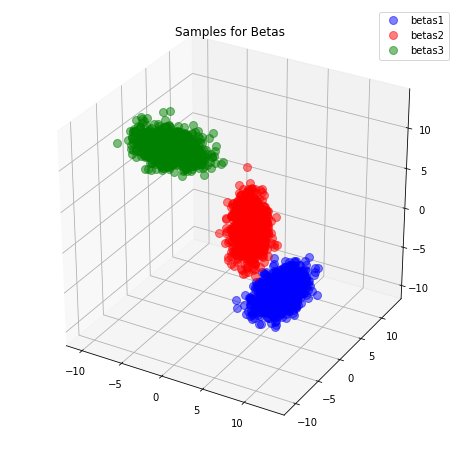

In [56]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10   
ax.plot(betas.T[0,:1000], betas.T[1,:1000], betas.T[2,:1000], 'o', markersize=8, color='blue', alpha=0.5, label='betas1')
ax.plot(betas.T[0,1000:2000], betas.T[1,1000:2000], betas.T[2,1000:2000], 'o', markersize=8, color='red', alpha=0.5, label='betas2')
ax.plot(betas.T[0,2000:], betas.T[1,2000:], betas.T[2,2000:], 'o', markersize=8, color='green', alpha=0.5, label='betas3')

plt.title('Samples for Betas')
ax.legend(loc='upper right')

plt.show()

/Users/phumon/opt/anaconda3/envs/latent_features/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:189: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([xs, ys, zs, np.ones_like(xs)])


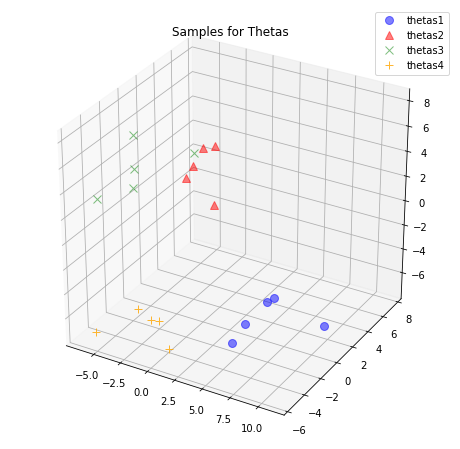

In [57]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10   
ax.plot(thetas.T[0,:5], thetas.T[1,:5], thetas.T[2,:5], 'o', markersize=8, color='blue', alpha=0.5, label='thetas1')
ax.plot(thetas.T[0,5:10], thetas.T[1,5:10], thetas.T[2,5:10], '^', markersize=8, color='red', alpha=0.5, label='thetas2')
ax.plot(thetas.T[0,10:15], thetas.T[1,10:15], thetas.T[2,10:15], 'x', markersize=8, color='green', alpha=0.5, label='thetas3')
ax.plot(thetas.T[0,15:20], thetas.T[1,15:20], thetas.T[2,15:20], '+', markersize=8, color='orange', alpha=0.8, label='thetas4')
#ax.plot(thetas.T[0,12:15], thetas.T[1,12:15], thetas.T[2,12:15], '^', markersize=8, color='cyan', alpha=0.5, label='thetas4')
#ax.plot(thetas.T[0,15:18], thetas.T[1,15:18], thetas.T[2,15:18], '^', markersize=8, color='black', alpha=0.5, label='thetas5')
plt.title('Samples for Thetas')
ax.legend(loc='upper right')

plt.show()

# Samplin from distributions

In [ ]:
model_names = ["model_{}".format(i) for i in range(n_models)]
items_names_dist1 = [f"data_dist1_{i}" for i in range(n_items)]
items_names_dist2 = [f"data_dist2_{i}" for i in range(n_items)]

#with open(os.path.join(response_dir, f'params_sync_dim{dimension}_mean{dist_mean}_alpha-{discr}-{alpha_std:.2f}_theta-{ability}-{item_param_std:.2f}_irt_all_coded.p'), 'wb') as handle:
#    pickle.dump(param_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)



for i in range(50):
    lik_dist1 = dist.Bernoulli(probs).sample()
    lik_dist2 = dist.Bernoulli(probs2).sample()
    
    df1 = pd.DataFrame(data=lik_dist1.numpy().astype(int),
                  index=model_names,
                  columns=items_names_dist1)
    df1.index.names = ['userid']
    df2 = pd.DataFrame(data=lik_dist2.numpy().astype(int),
                  index=model_names,
                  columns=items_names_dist2)
    df2.index.names = ['userid']
    
    response_output1=os.path.join(response_dir, f'dist1_version{i}_irt_all_coded.csv')
    df1.to_csv(response_output1)
    
    response_output2=os.path.join(response_dir, f'dist2_version{i}_irt_all_coded.csv')
    df2.to_csv(response_output2)

    


# For Multivariate Nomal

# For 1D

In [ ]:
# Generate betas
betas = pyro.sample("b", dist.Normal(torch.zeros(n_items), item_params_std))

# Generate gamma
log_gamma = pyro.sample("log c", dist.Normal(torch.zeros(n_items), item_params_std))
gamma = sigmoid(log_gamma)

# Generate alphas
alphas = pyro.sample(
            "a",
            dist.LogNormal(
                alpha_dist["mu"] * torch.ones(n_items),
                alpha_dist["std"],
            ),
        )

# Generate thetas
thetas = pyro.sample(
            "theta",
            dist.Normal(
                theta_dist["mu"] * torch.ones(n_models),
                theta_dist["std"],
            ),
        )

#alphas = positive_transform(alphas)
#thetas = positive_transform(thetas)
lik = dist.Bernoulli(
            gamma[None, :]
            + (1.0 - gamma[None, :])
            * sigmoid(alphas[None, :] * (thetas[:, None] - betas[None, :]))
        ).sample()
    
    
responses=lik

In [ ]:
model_names = ["model_{}".format(i) for i in range(n_models)]
items_names = ["data_{}".format(i) for i in range(n_items)]

df = pd.DataFrame(data = responses.numpy().astype(int),  
                        index = model_names,  
                        columns = items_names) 
df.index.names = ['userid']
df
#df.to_csv('/Users/phumon/Documents/Research/nlu-test-sets/data_synthetic/sync_irt_all_coded.csv')

# Multiple Dim

In [ ]:
n_models, n_items = 18, 1000
dimension=6
item_params_std=1

alpha_dist={}
alpha_dist = {"mu": 0.0, "std":0.3}
theta_dist = {"mu": 0.0, "std":1}

positive_transform = lambda x: torch.log(1 + torch.exp(x))


In [ ]:
# Generate betas
betas = pyro.sample("b", dist.Normal(torch.zeros(n_items, dimension), item_params_std))

# Generate gamma
log_gamma = pyro.sample("log c", dist.Normal(torch.zeros(n_items), item_params_std))
gamma = sigmoid(log_gamma)

# Generate alphas
alphas = pyro.sample(
            "a",
            dist.LogNormal(
                alpha_dist["mu"] * torch.ones(n_items, dimension),
                alpha_dist["std"],
            ),
        )

# Generate thetas
thetas = pyro.sample(
            "theta",
            dist.Normal(
                theta_dist["mu"] * torch.ones(n_models, dimension),
                theta_dist["std"],
            ),
        )

#alphas = positive_transform(alphas)
#thetas = positive_transform(thetas)
if dimension > 1:
    lik = pyro.sample(
            "likelihood",
            dist.Bernoulli(
                gamma[None, :]
                + (1.0 - gamma[None, :])
                * sigmoid(
                    torch.sum(alphas[None, :, :] * (thetas[:, None] - betas[None, :]).squeeze(), dim=-1)  
                )
            )
        )

    
responses=lik

In [ ]:
betas

In [ ]:
model_names = ["model_{}".format(i) for i in range(n_models)]
items_names = ["data_{}".format(i) for i in range(n_items)]

df = pd.DataFrame(data = responses.numpy().astype(int),  
                        index = model_names,  
                        columns = items_names) 
df.index.names = ['userid']
df


In [ ]:
df.to_csv('/Users/phumon/Documents/Research/nlu-test-sets/data_synthetic/dim6/sync_irt_all_coded.csv')

# Load trained params

In [ ]:
repo = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))

In [ ]:
def get_stats_CI(params, p=0.95, dist='normal'):
    '''
    Method to calculate lower and upper quantiles defined by `p`, mean, and variance of `param`
    
    Args:
        params: Dictionary of distribution parameters for each item keyed according to the 
                parametric distribution defined by `dist`.
        p:      Percent of distribution covered by the lower and upper interval values for each
                parameter.
        dist:   Name of parametric distribution
    
    Returns:
        return: {
            'lower': Lower interval values of each parameter,
            'upper': Upper interval values of each parameter,
            'mean' : Mean of each parameter,
            'var'  : Variance of each parameter
        }
    '''
    stats = {}
    if dist == 'normal':
        L,U = scipy.stats.norm.interval(p,loc=params['mu'], scale=torch.exp(params['logstd']))
        M,V = scipy.stats.norm.stats(loc=params['mu'], scale=torch.exp(params['logstd']))
    elif dist == 'log-normal':
        L,U = scipy.stats.lognorm.interval(p, s=torch.exp(params['logstd']), scale=torch.exp(params['mu']))
        M,V = scipy.stats.lognorm.stats(s=torch.exp(params['logstd']), scale=torch.exp(params['mu']))
    elif dist == 'beta':
        L,U = scipy.stats.beta.interval(p,a=params['alpha'], b=params['beta'])
        M,V = scipy.stats.beta.stats(a=params['alpha'], b=params['beta'])
    else:
        raise TypeError(f'Distribution type {dist} not supported.')
    
    return {
        'lower':[L],
        'upper':[U],
        'mean':[M],
        'var':[V],
    }

In [ ]:
def get_plot_stats(exp_dir, alpha_dist, theta_dist, transforms, p = 0.95):
    '''
    Method to return plotting statistics for 3 parameter IRT model parameters.
    
    Args:
        exp_dir:          Path to 3 parameter IRT parameters and responses.
        alpha_dist:       Name of the item discrimination [a] distribution.
        theta_dist:       Name of the responder ability [t] distribution.
        transforms:       Dictionary of transformations to apply to each parameter type
                          where keys are parameter names and values are functions.
        p:                Percent of distribution covered by the lower and upper interval 
                          values for each parameter.
    
    Returns:
        param_plot_stats: Dictionary of parameter plot statistics where keys are parameter
                          names and values are plot statistics dictionaries as defined by
                          get_stats_CI().
    '''
    param_dists = {
        'a':alpha_dist,
        'b':'normal',
        'g':'normal',
        't':theta_dist,
    }

    dist_params = {
        'normal':['mu', 'logstd'],
        'log-normal':['mu', 'logstd'],
        'beta':['alpha', 'beta'],
    }

    pyro.clear_param_store()
    pyro.get_param_store().load(os.path.join(exp_dir, 'params.p'))

    with torch.no_grad():
        pyro_param_dict = dict(pyro.get_param_store().named_parameters())
    
    # get stats for plotting
    param_plot_stats = {}

    for param, param_dist in param_dists.items():
        temp_params = dist_params[param_dist]

        for idx, (p1_orig, p2_orig) in enumerate(zip(pyro_param_dict[f'{param} {temp_params[0]}'], pyro_param_dict[f'{param} {temp_params[1]}'])):
            p1, p2 = p1_orig.detach(), p2_orig.detach()
            
            temp_stats_df = pd.DataFrame.from_dict(
                get_stats_CI(
                    params = {
                        temp_params[0]:p1,
                        temp_params[1]:p2,
                    },
                    p=p,
                    dist = param_dist,
                )
            )
            
            temp_stats_df = temp_stats_df.applymap(transforms[param])
        
            if idx == 0:
                param_plot_stats[param] = temp_stats_df
            else:
                param_plot_stats[param] = param_plot_stats[param].append(temp_stats_df, ignore_index = True)
    
    return param_plot_stats

In [ ]:
# distribution and transformation
alpha_dist = 'log-normal'
alpha_transf = 'standard'
theta_dist = 'normal'
theta_transf = 'standard'

exp_dir = os.path.join(repo, 'params_sync_d6_lr1e-3', f'alpha-lognormal-identity-dim6_theta-normal-identity_nosubsample_1.00_0.25')
p = 0.95


select_ts = {
    'standard':lambda x:x,
    'positive':lambda x:torch.log(1+torch.exp(torch.tensor(x))),
    'sigmoid':lambda x:sigmoid(torch.tensor(x)),
}

transforms = {
    'a':select_ts[alpha_transf],
    'b':select_ts['standard'],
    'g':select_ts['sigmoid'],
    't':select_ts[theta_transf],
}


param_plot_stats = get_plot_stats(
    exp_dir,
    alpha_dist,
    theta_dist,
    transforms,
    p = 0.95
)
    


In [ ]:
predicted_mean_b = np.vstack(param_plot_stats['b']['mean'])
predicted_lower_b = np.vstack(param_plot_stats['b']['lower'])
predicted_upper_b = np.vstack(param_plot_stats['b']['upper'])

In [ ]:
predicted_mean_b[0]

In [ ]:
predicted_upper_b[0]

In [ ]:
betas.numpy()

In [ ]:
count=0
for row in np.greater(predicted_upper_b,betas.numpy()).astype(int):
    if 0 in row:
        print(row)
        count += 1
print(count/betas.size(0))